In [90]:
import pandas as pd
import numpy as np
import random
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

## Configure devices

In [91]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using mps device


In [92]:
random_seed = 42

torch.use_deterministic_algorithms(True)
torch.manual_seed(random_seed)

## Load Dataset

In [93]:
base_train_df = pd.read_csv('./data/train_data.csv')
base_test_df = pd.read_csv('./data/test_data.csv')

base_train_df.head()

,SalePrice,YearBuilt,Size(sqf),Floor,HallwayType,HeatingType,AptManageType,N_Parkinglot(Ground),N_Parkinglot(Basement),TimeToBusStop,TimeToSubway,N_manager,N_elevators,SubwayStation,N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_SchoolNearBy(Total)
0,141592,2006,814,3,terraced,individual_heating,management_in_trust,111.0,184.0,5min~10min,10min~15min,3.0,0.0,Kyungbuk_uni_hospital,5,6.0,9.0
1,51327,1985,587,8,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0
2,48672,1985,587,6,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0
3,380530,2006,2056,8,terraced,individual_heating,management_in_trust,249.0,536.0,0~5min,0-5min,5.0,11.0,Sin-nam,5,3.0,7.0
4,78318,1992,644,2,mixed,individual_heating,self_management,142.0,79.0,5min~10min,15min~20min,4.0,8.0,Myung-duk,3,9.0,14.0


## Data Preprocessing

In [94]:
def index_encode(df: pd.DataFrame, column: str, mappings: dict = None) -> tuple[pd.DataFrame, dict]:
    if not column in df.columns or df[column].dtype != 'object':
        return df, {}
    
    unique_values = df[column].unique()
    if mappings is not None:
        unique_values = [value for value in unique_values]
        missings = [value for value in unique_values if value not in mappings]
        if len(missings) > 0:
            raise ValueError(f"Missing values in mappings: {missings}")
    else:
        mappings = {value: index for index, value in enumerate(unique_values)}

    encoded_df = df.copy()
    encoded_df[column] = encoded_df[column].map(mappings)

    return encoded_df, mappings

def one_hot_encode(df: pd.DataFrame, column: str) -> pd.DataFrame:
    if not column in df.columns:
        return df

    cols = pd.get_dummies(df[column], prefix=column)

    encoded_df = pd.concat([df, cols], axis=1)
    encoded_df.drop(column, axis=1, inplace=True)

    return encoded_df

In [95]:
base_train_df.head()

,SalePrice,YearBuilt,Size(sqf),Floor,HallwayType,HeatingType,AptManageType,N_Parkinglot(Ground),N_Parkinglot(Basement),TimeToBusStop,TimeToSubway,N_manager,N_elevators,SubwayStation,N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_SchoolNearBy(Total)
0,141592,2006,814,3,terraced,individual_heating,management_in_trust,111.0,184.0,5min~10min,10min~15min,3.0,0.0,Kyungbuk_uni_hospital,5,6.0,9.0
1,51327,1985,587,8,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0
2,48672,1985,587,6,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0
3,380530,2006,2056,8,terraced,individual_heating,management_in_trust,249.0,536.0,0~5min,0-5min,5.0,11.0,Sin-nam,5,3.0,7.0
4,78318,1992,644,2,mixed,individual_heating,self_management,142.0,79.0,5min~10min,15min~20min,4.0,8.0,Myung-duk,3,9.0,14.0


### Categorical data

In [96]:
train_df = base_train_df.copy()
test_df = base_test_df.copy()

#### HallwayType

In [97]:
base_train_df["HallwayType"].unique()

array(['terraced', 'corridor', 'mixed'], dtype=object)

In [98]:
# hallway_type_mappings = {
#     "terraced": 0,
#     "mixed": 1,
#     "corridor": 2
# }

# train_df, _ = index_encode(train_df, "HallwayType", hallway_type_mappings)
# test_df, _ = index_encode(test_df, "HallwayType", hallway_type_mappings)

train_df = one_hot_encode(train_df, "HallwayType")
test_df = one_hot_encode(test_df, "HallwayType")

# print("unique values:", train_df["HallwayType"].unique())
train_df.head()

,SalePrice,YearBuilt,Size(sqf),Floor,HeatingType,AptManageType,N_Parkinglot(Ground),N_Parkinglot(Basement),TimeToBusStop,TimeToSubway,N_manager,N_elevators,SubwayStation,N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_SchoolNearBy(Total),HallwayType_corridor,HallwayType_mixed,HallwayType_terraced
0,141592,2006,814,3,individual_heating,management_in_trust,111.0,184.0,5min~10min,10min~15min,3.0,0.0,Kyungbuk_uni_hospital,5,6.0,9.0,False,False,True
1,51327,1985,587,8,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0,True,False,False
2,48672,1985,587,6,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0,True,False,False
3,380530,2006,2056,8,individual_heating,management_in_trust,249.0,536.0,0~5min,0-5min,5.0,11.0,Sin-nam,5,3.0,7.0,False,False,True
4,78318,1992,644,2,individual_heating,self_management,142.0,79.0,5min~10min,15min~20min,4.0,8.0,Myung-duk,3,9.0,14.0,False,True,False


#### HeatingType

In [99]:
base_train_df["HeatingType"].unique()

array(['individual_heating', 'central_heating'], dtype=object)

In [100]:
# heating_type_mappings = {
#     "central_heating": 0,
#     "individual_heating": 1,
# }

# train_df, _ = index_encode(train_df, "HeatingType", heating_type_mappings)
# test_df, _ = index_encode(test_df, "HeatingType", heating_type_mappings)

train_df = one_hot_encode(train_df, "HeatingType")
test_df = one_hot_encode(test_df, "HeatingType")

# print("unique values:", train_df["HeatingType"].unique())
train_df.head()

,SalePrice,YearBuilt,Size(sqf),Floor,AptManageType,N_Parkinglot(Ground),N_Parkinglot(Basement),TimeToBusStop,TimeToSubway,N_manager,N_elevators,SubwayStation,N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_SchoolNearBy(Total),HallwayType_corridor,HallwayType_mixed,HallwayType_terraced,HeatingType_central_heating,HeatingType_individual_heating
0,141592,2006,814,3,management_in_trust,111.0,184.0,5min~10min,10min~15min,3.0,0.0,Kyungbuk_uni_hospital,5,6.0,9.0,False,False,True,False,True
1,51327,1985,587,8,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0,True,False,False,False,True
2,48672,1985,587,6,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0,True,False,False,False,True
3,380530,2006,2056,8,management_in_trust,249.0,536.0,0~5min,0-5min,5.0,11.0,Sin-nam,5,3.0,7.0,False,False,True,False,True
4,78318,1992,644,2,self_management,142.0,79.0,5min~10min,15min~20min,4.0,8.0,Myung-duk,3,9.0,14.0,False,True,False,False,True


#### AptManageType

In [101]:
base_train_df["AptManageType"].unique()

array(['management_in_trust', 'self_management'], dtype=object)

In [102]:
# apt_manage_type_mappings = {
#     "self_management": 0,
#     "management_in_trust": 1,
# }

# train_df, _ = index_encode(train_df, "AptManageType", apt_manage_type_mappings)
# test_df, _ = index_encode(test_df, "AptManageType", apt_manage_type_mappings)

train_df = one_hot_encode(train_df, "AptManageType")
test_df = one_hot_encode(test_df, "AptManageType")

# print("unique values:", train_df["AptManageType"].unique())
train_df.head()

,SalePrice,YearBuilt,Size(sqf),Floor,N_Parkinglot(Ground),N_Parkinglot(Basement),TimeToBusStop,TimeToSubway,N_manager,N_elevators,...,N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_SchoolNearBy(Total),HallwayType_corridor,HallwayType_mixed,HallwayType_terraced,HeatingType_central_heating,HeatingType_individual_heating,AptManageType_management_in_trust,AptManageType_self_management
0,141592,2006,814,3,111.0,184.0,5min~10min,10min~15min,3.0,0.0,...,5,6.0,9.0,False,False,True,False,True,True,False
1,51327,1985,587,8,80.0,76.0,0~5min,5min~10min,2.0,2.0,...,3,12.0,4.0,True,False,False,False,True,False,True
2,48672,1985,587,6,80.0,76.0,0~5min,5min~10min,2.0,2.0,...,3,12.0,4.0,True,False,False,False,True,False,True
3,380530,2006,2056,8,249.0,536.0,0~5min,0-5min,5.0,11.0,...,5,3.0,7.0,False,False,True,False,True,True,False
4,78318,1992,644,2,142.0,79.0,5min~10min,15min~20min,4.0,8.0,...,3,9.0,14.0,False,True,False,False,True,False,True


#### TimeToBusStop

In [103]:
base_train_df["TimeToBusStop"].unique()

array(['5min~10min', '0~5min', '10min~15min'], dtype=object)

In [104]:
# time_to_bus_stop_mappings = {
#     "10min~15min": 0,
#     "5min~10min": 1,
#     "0~5min": 2
# }

# train_df, _ = index_encode(train_df, "TimeToBusStop", time_to_bus_stop_mappings)
# test_df, _ = index_encode(test_df, "TimeToBusStop", time_to_bus_stop_mappings)

train_df = one_hot_encode(train_df, "TimeToBusStop")
test_df = one_hot_encode(test_df, "TimeToBusStop")

# print("unique values:", train_df["TimeToBusStop"].unique())
train_df.head()

,SalePrice,YearBuilt,Size(sqf),Floor,N_Parkinglot(Ground),N_Parkinglot(Basement),TimeToSubway,N_manager,N_elevators,SubwayStation,...,HallwayType_corridor,HallwayType_mixed,HallwayType_terraced,HeatingType_central_heating,HeatingType_individual_heating,AptManageType_management_in_trust,AptManageType_self_management,TimeToBusStop_0~5min,TimeToBusStop_10min~15min,TimeToBusStop_5min~10min
0,141592,2006,814,3,111.0,184.0,10min~15min,3.0,0.0,Kyungbuk_uni_hospital,...,False,False,True,False,True,True,False,False,False,True
1,51327,1985,587,8,80.0,76.0,5min~10min,2.0,2.0,Daegu,...,True,False,False,False,True,False,True,True,False,False
2,48672,1985,587,6,80.0,76.0,5min~10min,2.0,2.0,Daegu,...,True,False,False,False,True,False,True,True,False,False
3,380530,2006,2056,8,249.0,536.0,0-5min,5.0,11.0,Sin-nam,...,False,False,True,False,True,True,False,True,False,False
4,78318,1992,644,2,142.0,79.0,15min~20min,4.0,8.0,Myung-duk,...,False,True,False,False,True,False,True,False,False,True


#### TimeToSubway

In [105]:
base_train_df["TimeToSubway"].unique()

array(['10min~15min', '5min~10min', '0-5min', '15min~20min',
       'no_bus_stop_nearby'], dtype=object)

In [106]:
# time_to_subway_mappings = {
#     "no_bus_stop_nearby": 0,
#     "15min~20min": 1,
#     "10min~15min": 2,
#     "5min~10min": 3,
#     "0-5min": 4
# }

# train_df, _ = index_encode(train_df, "TimeToSubway", time_to_subway_mappings)
# test_df, _ = index_encode(test_df, "TimeToSubway", time_to_subway_mappings)

train_df = one_hot_encode(train_df, "TimeToSubway")
test_df = one_hot_encode(test_df, "TimeToSubway")

# print("unique values:", train_df["TimeToSubway"].unique())
train_df.head()

,SalePrice,YearBuilt,Size(sqf),Floor,N_Parkinglot(Ground),N_Parkinglot(Basement),N_manager,N_elevators,SubwayStation,N_FacilitiesInApt,...,AptManageType_management_in_trust,AptManageType_self_management,TimeToBusStop_0~5min,TimeToBusStop_10min~15min,TimeToBusStop_5min~10min,TimeToSubway_0-5min,TimeToSubway_10min~15min,TimeToSubway_15min~20min,TimeToSubway_5min~10min,TimeToSubway_no_bus_stop_nearby
0,141592,2006,814,3,111.0,184.0,3.0,0.0,Kyungbuk_uni_hospital,5,...,True,False,False,False,True,False,True,False,False,False
1,51327,1985,587,8,80.0,76.0,2.0,2.0,Daegu,3,...,False,True,True,False,False,False,False,False,True,False
2,48672,1985,587,6,80.0,76.0,2.0,2.0,Daegu,3,...,False,True,True,False,False,False,False,False,True,False
3,380530,2006,2056,8,249.0,536.0,5.0,11.0,Sin-nam,5,...,True,False,True,False,False,True,False,False,False,False
4,78318,1992,644,2,142.0,79.0,4.0,8.0,Myung-duk,3,...,False,True,False,False,True,False,False,True,False,False


#### SubwayStation

In [107]:
base_train_df["SubwayStation"].unique()

array(['Kyungbuk_uni_hospital', 'Daegu', 'Sin-nam', 'Myung-duk',
       'Chil-sung-market', 'Bangoge', 'Banwoldang', 'no_subway_nearby'],
      dtype=object)

In [108]:
train_df = one_hot_encode(train_df, "SubwayStation")
test_df = one_hot_encode(train_df, "SubwayStation")

train_df.head()

,SalePrice,YearBuilt,Size(sqf),Floor,N_Parkinglot(Ground),N_Parkinglot(Basement),N_manager,N_elevators,N_FacilitiesInApt,N_FacilitiesNearBy(Total),...,TimeToSubway_5min~10min,TimeToSubway_no_bus_stop_nearby,SubwayStation_Bangoge,SubwayStation_Banwoldang,SubwayStation_Chil-sung-market,SubwayStation_Daegu,SubwayStation_Kyungbuk_uni_hospital,SubwayStation_Myung-duk,SubwayStation_Sin-nam,SubwayStation_no_subway_nearby
0,141592,2006,814,3,111.0,184.0,3.0,0.0,5,6.0,...,False,False,False,False,False,False,True,False,False,False
1,51327,1985,587,8,80.0,76.0,2.0,2.0,3,12.0,...,True,False,False,False,False,True,False,False,False,False
2,48672,1985,587,6,80.0,76.0,2.0,2.0,3,12.0,...,True,False,False,False,False,True,False,False,False,False
3,380530,2006,2056,8,249.0,536.0,5.0,11.0,5,3.0,...,False,False,False,False,False,False,False,False,True,False
4,78318,1992,644,2,142.0,79.0,4.0,8.0,3,9.0,...,False,False,False,False,False,False,False,True,False,False


### Normalization

In [109]:
base_train_df.columns

Index(['SalePrice', 'YearBuilt', 'Size(sqf)', 'Floor', 'HallwayType',
       'HeatingType', 'AptManageType', 'N_Parkinglot(Ground)',
       'N_Parkinglot(Basement)', 'TimeToBusStop', 'TimeToSubway', 'N_manager',
       'N_elevators', 'SubwayStation', 'N_FacilitiesInApt',
       'N_FacilitiesNearBy(Total)', 'N_SchoolNearBy(Total)'],
      dtype='object')

In [110]:
def normalize(df: pd.DataFrame, columns: list[str]) -> pd.DataFrame:
    normalized_df = df.copy()
    for column in columns:
        mean = normalized_df[column].mean()
        std = normalized_df[column].std()
        normalized_df[column] = (normalized_df[column] - mean) / std
    return normalized_df


columns_to_normalize = [
    'YearBuilt', 'Size(sqf)', 
    'Floor', 
    'N_Parkinglot(Ground)',
    'N_Parkinglot(Basement)', 
    'N_manager',
    'N_elevators',  
    'N_FacilitiesInApt',
    'N_FacilitiesNearBy(Total)', 
    'N_SchoolNearBy(Total)']

train_df = normalize(train_df, columns_to_normalize)
test_df = normalize(test_df, columns_to_normalize)

### Data loaders

In [111]:
X_train, y_train = train_df.drop(columns=["SalePrice"]).astype(np.float32), train_df["SalePrice"].astype(np.float32)
X_test, y_test = test_df.drop(columns=["SalePrice"]).astype(np.float32), test_df["SalePrice"].astype(np.float32)

X_train.shape, y_train.shape

((4124, 33), (4124,))

In [112]:
X_train_tensor, y_train_tensor = torch.tensor(X_train.values, dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor, y_test_tensor = torch.tensor(X_test.values, dtype=torch.float32), torch.tensor(y_test.values, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

In [113]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)

In [114]:
batch_size = 256

train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=seed_worker, generator=g)
test_dl = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=seed_worker, generator=g)

## Model definition

In [115]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size: int, output_size: int = 1, dropout: float = 0.2):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512, output_size)
        )

    def forward(self, x):
        x = self.seq(x)
        return x

## Training

In [116]:
criterion = nn.L1Loss()

def train_loop(dataloader, model, optimizer):
    model.train()

    total_loss = 0
    total_batches = len(dataloader)

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        pred = model(X)
        y = y.view_as(pred)

        loss = criterion(pred, y)
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss.item()

    return total_loss/total_batches


def test_loop(dataloader, model):
    model.eval()

    total_loss = 0
    total_batches = len(dataloader)

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)

            pred = model(X)
            y = y.view_as(pred)

            total_loss += criterion(pred, y).item()

    return total_loss/total_batches

In [117]:
def plot_training(train_losses, test_losses):
    import matplotlib.pyplot as plt

    plt.plot(train_losses, label='train')
    plt.plot(test_losses, label='test')
    plt.legend()
    plt.show()

def train_and_evaluate(model, epochs, learning_rate=0.01):
    train_losses = []
    test_losses = []

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for t in range(epochs):
        avg_train_loss = train_loop(train_dl, model, optimizer)
        avg_test_loss = test_loop(test_dl, model)

        train_losses.append(avg_train_loss)
        test_losses.append(avg_test_loss)

        print(f"Epoch {t+1}/{epochs} - Train Loss: {avg_train_loss:.4f} - Test Loss: {avg_test_loss:.4f}")

    plot_training(train_losses, test_losses)

Epoch 1/500 - Train Loss: 221760.3686 - Test Loss: 226415.0404
Epoch 2/500 - Train Loss: 222463.9789 - Test Loss: 226244.0386
Epoch 3/500 - Train Loss: 220098.9724 - Test Loss: 225019.5685
Epoch 4/500 - Train Loss: 219591.3171 - Test Loss: 219468.5653
Epoch 5/500 - Train Loss: 209569.6131 - Test Loss: 200581.5749
Epoch 6/500 - Train Loss: 175979.0873 - Test Loss: 151566.3964
Epoch 7/500 - Train Loss: 113747.3718 - Test Loss: 80631.8601
Epoch 8/500 - Train Loss: 69890.2904 - Test Loss: 61567.8913
Epoch 9/500 - Train Loss: 58162.0538 - Test Loss: 55010.1893
Epoch 10/500 - Train Loss: 52314.9908 - Test Loss: 51176.4932
Epoch 11/500 - Train Loss: 49674.1452 - Test Loss: 49319.6270
Epoch 12/500 - Train Loss: 47948.0267 - Test Loss: 47806.4053
Epoch 13/500 - Train Loss: 46538.6882 - Test Loss: 46620.0516
Epoch 14/500 - Train Loss: 45253.5680 - Test Loss: 45463.2719
Epoch 15/500 - Train Loss: 44329.4982 - Test Loss: 44803.1122
Epoch 16/500 - Train Loss: 43507.1974 - Test Loss: 43932.5049
Epoc

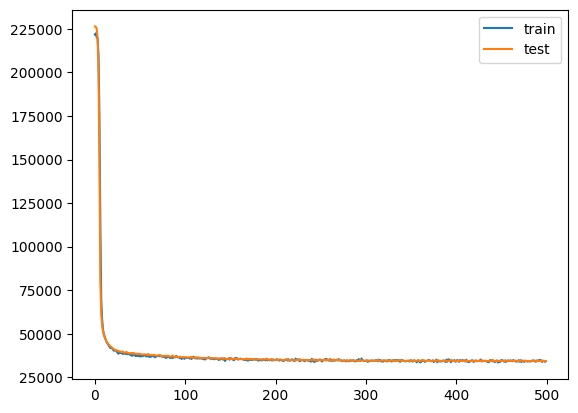

In [118]:
vector_size = X_train.shape[1]

model = NeuralNetwork(input_size=vector_size)
model.to(device)

train_and_evaluate(model, epochs=500, learning_rate=3e-4)

## Evaluate

In [119]:
def price_to_class(price: float) -> int:
    if price <= 100_000:
        return 0  # cheap
    elif price <= 350_000:
        return 1  # average
    else:
        return 2  # expensive
    

def format_price(val: float) -> str:
    # If the value is an integer, format as an integer.
    if val.is_integer():
        return f"{int(val):,}".replace(",", " ")
    else:
        return f"{val:,}".replace(",", " ")

In [120]:
def test(model, verbose=False):
    model.eval()
    with torch.no_grad():
        X_test_device = X_test_tensor.to(device)
        y_test_device = y_test_tensor.to(device)
        predictions = model(X_test_device)

    predicted_classes = [price_to_class(p.item()) for p in predictions]
    true_classes = [price_to_class(t.item()) for t in y_test_device]

    correct = sum(p == t for p, t in zip(predicted_classes, true_classes))
    total = len(true_classes)
    accuracy = correct / total * 100

    if verbose:
        for pred, true in zip(predictions[:5], y_test_device[:5]):
            pred_val = pred.item()
            true_val = true.item()
            print(f"Prediction: {format_price(pred_val):20}  |  Ground Truth: {format_price(true_val)}")

    return accuracy


#### Class accuracy

In [121]:
acc = test(model, verbose=True)

print(f"Accuracy: {acc:.2f}%")

Prediction: 198 243.65625         |  Ground Truth: 141 592
Prediction: 69 840.828125         |  Ground Truth: 51 327
Prediction: 70 360.5859375        |  Ground Truth: 48 672
Prediction: 376 181.03125         |  Ground Truth: 380 530
Prediction: 126 372.8515625       |  Ground Truth: 78 318
Accuracy: 86.71%
